<a href="https://colab.research.google.com/github/ljn1999/APS360-Applied-Fundamentals-of-Machine-Learning/blob/master/Lab4/Lab_4_Data_Imputation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: Data Imputation using an Autoencoder

**Deadline**: Thursday, March 5, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**TA**: Chris Lucasius

In this lab, you will build and train an autoencoder to impute (or "fill in") missing data. 

We will be using the
Adult Data Set provided by the UCI Machine Learning Repository [1], available 
at https://archive.ics.uci.edu/ml/datasets/adult.
The data set contains census record files of adults, including their
age, martial status, the type of work they do, and other features. 

Normally, people use this data set to build a supervised classification
model to classify whether a person is a high income earner.
We will not use the dataset for this original intended purpose.

Instead, we will perform the task of imputing (or "filling in") missing values in the dataset. For example,
we may be missing one person's martial status, and another person's age, and
a third person's level of education. Our model will predict the missing features 
based on the information that we do have about each person.

We will use a variation of a denoising autoencoder to solve this data imputation
problem. Our autoencoder will be trained using inputs that have one categorical feature artificially
removed, and the goal of the autoencoder is to correctly reconstruct all features,
including the one removed from the input.

In the process, you are expected to learn to:

1. Clean and process continuous and categorical data for machine learning.
2. Implement an autoencoder that takes continuous and categorical (one-hot) inputs.
3. Tune the hyperparameters of an autoencoder.
4. Use baseline models to help interpret model performance.

[1] Dua, D. and Karra Taniskidou, E. (2017). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.


### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information (.html files are also acceptable).

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1uzJGH-UGknqfxt66TgppxJoAzfNeDaCN#scrollTo=zbnrp2ig1pps

In [ ]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
import matplotlib.pyplot as plt

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [ ]:
import pandas as pd

# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [ ]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [ ]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

Like numpy arrays and torch tensors, 
pandas data frames can be sliced. For example, we can
display the first 3 rows of the data frame (3 records) below.

In [ ]:
df[:3] # show the first 3 records

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States


Alternatively, we can slice based on column names, 
for example `df["race"]`, `df["hr"]`, or even index multiple columns 
like below.

In [ ]:
subdf = df[["age", "yredu", "capgain", "caploss", "workhr"]]
subdf[:3] # show the first 3 records

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40


Numpy works nicely with pandas, like below:

In [ ]:
np.sum(subdf["caploss"])

2842700

Just like numpy arrays, you can modify
entire columns of data rather than one scalar element at a time.
For example, the code  

`df["age"] = df["age"] + 1` 

would increment everyone's age by 1.

In [ ]:
print('max value of age:', (df['age']).max(), ' min value of age:', (df['age']).min(), ' avg value of age:', (df['age']).mean())
print('max value of yredu:', (df['yredu']).max(), ' min value of yredu:', (df['yredu']).min(), ' avg value of yredu:', (df['yredu']).mean())
print('max value of capgain:', (df['capgain']).max(), ' min value of capgain:', (df['capgain']).min(), ' avg value of capgain:', (df['capgain']).mean())
print('max value of caploss:', (df['caploss']).max(), ' min value of caploss:', (df['caploss']).min(), ' avg value of caploss:', (df['caploss']).mean())
print('max value of workhr:', (df['workhr']).max(), ' min value of workhr:', (df['workhr']).min(), ' avg value of workhr:', (df['workhr']).mean())

max value of age: 90  min value of age: 17  avg value of age: 38.58164675532078
max value of yredu: 16  min value of yredu: 1  avg value of yredu: 10.0806793403151
max value of capgain: 99999  min value of capgain: 0  avg value of capgain: 1077.6488437087312
max value of caploss: 4356  min value of caploss: 0  avg value of caploss: 87.303829734959
max value of workhr: 99  min value of workhr: 1  avg value of workhr: 40.437455852092995


In [ ]:
# normalize by (value - min) / (max - min)
df["age"] = (df["age"]-(df['age']).min()) / ((df['age']).max() - (df['age']).min())
df["yredu"] = (df["yredu"]-(df['yredu']).min()) / ((df['yredu']).max() - (df['yredu']).min())
df["capgain"] = (df["capgain"]-(df['capgain']).min()) / ((df['capgain']).max() - (df['capgain']).min())
df["caploss"] = (df["caploss"]-(df['caploss']).min()) / ((df['caploss']).max() - (df['caploss']).min())
df["workhr"] = (df["workhr"]-(df['workhr']).min()) / ((df['workhr']).max() - (df['workhr']).min())

### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
# hint: you can do something like this in pandas
sum(df["sex"] == " Female")

# number of female in the data set is 10771
# percentage of female = 10771/32561 = 0.33

10771

### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

In [ ]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [ ]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [ ]:
print(len(df))
print(len(df_with_missing))
# 1843 records contains missing features, 1843/32561 = 5.66% are removed

32561
1843


### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

In [ ]:
print(set(df_not_missing["work"]))

{' State-gov', ' Federal-gov', ' Private', ' Without-pay', ' Self-emp-inc', ' Self-emp-not-inc', ' Local-gov'}


We will be using a one-hot encoding to represent each of the categorical variables.
Our autoencoder will be trained using these one-hot encodings.

We will use the pandas function `get_dummies` to produce one-hot encodings
for all of the categorical variables in `df_not_missing`. 

In [ ]:
data = pd.get_dummies(df_not_missing)

In [ ]:
data[:3]

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.02174,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.00000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.00000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

In [ ]:
print(len(data.columns))
# the get_dummies function transferred strings in data set to values of 0 and 1, 
# for example, the column of work was transferred to 7 columns of work_ Federal-gov, 
# work_ Local-gov, etc. The value is 1 where the string value in the original data
# set matches the string in the column name, and 0 otherwise.

57


### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [ ]:
datanp = data.values.astype(np.float32)

In [ ]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

print(cat_index)
print(cat_values)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    # <----- TODO: WRITE YOUR CODE HERE ----->
    # You may find the variables `cat_index` and `cat_values` 
    # (created above) useful.
    #for i in range(0, len(onehot)):
      #if onehot[i] >= 1:
        #return cat_values[feature][i]
    return cat_values[feature][np.argmax(onehot)]


{'work': 5, 'marriage': 12, 'occupation': 19, 'edu': 33, 'relationship': 49, 'sex': 55}
{'work': ['Federal-gov', 'Local-gov', 'Private', 'Self-emp-inc', 'Self-emp-not-inc', 'State-gov', 'Without-pay'], 'marriage': ['Divorced', 'Married-AF-spouse', 'Married-civ-spouse', 'Married-spouse-absent', 'Never-married', 'Separated', 'Widowed'], 'occupation': ['Adm-clerical', 'Armed-Forces', 'Craft-repair', 'Exec-managerial', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Other-service', 'Priv-house-serv', 'Prof-specialty', 'Protective-serv', 'Sales', 'Tech-support', 'Transport-moving'], 'edu': ['10th', '11th', '12th', '1st-4th', '5th-6th', '7th-8th', '9th', 'Assoc-acdm', 'Assoc-voc', 'Bachelors', 'Doctorate', 'HS-grad', 'Masters', 'Preschool', 'Prof-school', 'Some-college'], 'relationship': ['Husband', 'Not-in-family', 'Other-relative', 'Own-child', 'Unmarried', 'Wife'], 'sex': ['Female', 'Male']}


In [ ]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

In [ ]:
# set the numpy seed for reproducibility
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.seed.html
np.random.seed(50)

# todo
indices = np.arange(len(data))
np.random.shuffle(indices)
split1 = int(len(indices) * 0.7)
split2 = int(len(indices) * 0.85)
train_indices, val_indices, test_indices = indices[:split1], indices[split1:split2], indices[split2:]
train_data = datanp[train_indices]
valid_data = datanp[val_indices]
test_data = datanp[test_indices]

print("length of training data:", len(train_data))
print("length of validation data:", len(valid_data))
print("length of test data:", len(test_data))

length of training data: 21502
length of validation data: 4608
length of test data: 4608


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [ ]:
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self):
        self.name = "AutoEncoder"
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.ReLU(),
            nn.Linear(57, 40),
            nn.ReLU(),
            nn.Linear(40, 20)
        )
        self.decoder = nn.Sequential(
            nn.Linear(20, 40),
            nn.ReLU(),
            nn.Linear(40, 57),
            nn.ReLU(),
            nn.Linear(57, 57), # TODO -- FILL OUT THE CODE HERE!
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

In [ ]:
# sigmoid forces the output to be a vector and each element to be between 0 and 1.
# Since in 'data', we used normalized features and used get_dummies function, 
# the values in 'data' are all between 0 and 1, we want the output of the autoencoder
# to match the 'data'. And the max in softmax output would be our prediction value.

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [ ]:
def zero_out_feature(records, feature):
    """ Set the feature missing in records, by setting the appropriate
    columns of records to 0
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    records[:, start_index:stop_index] = 0
    return records

def zero_out_random_feature(records):
    """ Set one random feature missing in records, by setting the 
    appropriate columns of records to 0
    """
    return zero_out_feature(records, random.choice(catcols))

def train(model, train_data, valid_data, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    iters, train_losses, valid_losses, train_acc, val_acc = [], [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            train_loss = criterion(recon, data)
            train_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        for data in valid_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            valid_loss = criterion(recon, data)

        iters.append(epoch)
        train_losses.append(float(train_loss)/batch_size)         # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        print("epoch number", epoch+1, "accuracy: ",train_acc[epoch])
        valid_losses.append(float(valid_loss)/batch_size)
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    plt.plot(iters, valid_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [ ]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
        #print(acc, total)
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

epoch number 1 accuracy:  0.5882631073078474
epoch number 2 accuracy:  0.6098657489225808
epoch number 3 accuracy:  0.6033237218243264
epoch number 4 accuracy:  0.6127104455399498
epoch number 5 accuracy:  0.6112144606703253
epoch number 6 accuracy:  0.6129352308312405
epoch number 7 accuracy:  0.6062691842619291
epoch number 8 accuracy:  0.6208027160264161
epoch number 9 accuracy:  0.6203221405760705
epoch number 10 accuracy:  0.6278950795274858


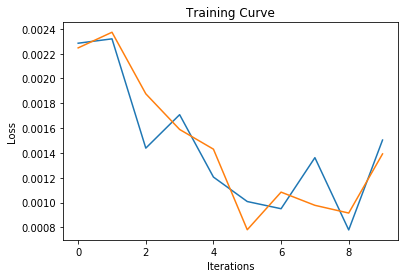

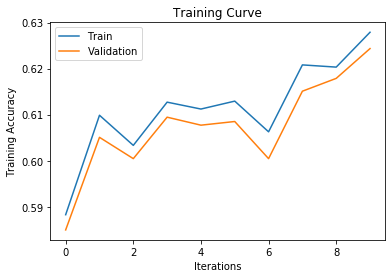

Final Training Accuracy: 0.6278950795274858
Final Validation Accuracy: 0.6243489583333334


In [ ]:
model = AutoEncoder()
train(model, train_data, valid_data, 16, 10, learning_rate=0.0008)

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

In [ ]:
def train_without_plots(model, train_data, valid_data, batch_size=64, num_epochs=5, learning_rate=1e-4):
    """ Training loop. You should update this."""
    torch.manual_seed(42)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    iters, losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        iters.append(epoch)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
        print("epoch number", epoch+1, "accuracy: ",train_acc[epoch]) 
        val_acc.append(get_accuracy(model, valid_loader))  # compute validation accuracy
        model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# hyperparameter set: batch_size = 16, num_epochs = 10, learning_rate = 0.001
# because in part c, I used a batch size of 16 and a learning rate of 0.001, 
# I increased the learning rate a little bit to speed up the learning.
model = AutoEncoder()
train_without_plots(model, train_data, valid_data, 16, 10, learning_rate=0.001)

epoch number 1 accuracy:  0.591712398846619
epoch number 2 accuracy:  0.6200973552847797
epoch number 3 accuracy:  0.6186168728490373
epoch number 4 accuracy:  0.6163457662853068
epoch number 5 accuracy:  0.614167674324869
epoch number 6 accuracy:  0.6175162000434068
epoch number 7 accuracy:  0.6275927820667845
epoch number 8 accuracy:  0.6322822683161257
epoch number 9 accuracy:  0.6352199795367873
epoch number 10 accuracy:  0.6302359470436859
Final Training Accuracy: 0.6302359470436859
Final Validation Accuracy: 0.6284360532407407


In [ ]:
# hyperparameter set: batch_size = 64, num_epochs = 20, learning_rate = 0.002
# because 16 is a relatively small batch size, and when I increase batch size, 
# the learning rate should also be increased.
model = AutoEncoder()
train_without_plots(model, train_data, valid_data, 64, 20, learning_rate=0.002)

epoch number 1 accuracy:  0.5713654543763371
epoch number 2 accuracy:  0.6098657489225808
epoch number 3 accuracy:  0.6167875856509472
epoch number 4 accuracy:  0.6225079837534493
epoch number 5 accuracy:  0.6066024865903947
epoch number 6 accuracy:  0.6239574613214275
epoch number 7 accuracy:  0.6218491303134592
epoch number 8 accuracy:  0.6252364121167023
epoch number 9 accuracy:  0.6191129507332651
epoch number 10 accuracy:  0.6162294980311909
epoch number 11 accuracy:  0.6223762130654513
epoch number 12 accuracy:  0.6221824326419247
epoch number 13 accuracy:  0.6342433262022138
epoch number 14 accuracy:  0.6239729637553095
epoch number 15 accuracy:  0.6261278020649242
epoch number 16 accuracy:  0.6286469475707687
epoch number 17 accuracy:  0.6406690850463522
epoch number 18 accuracy:  0.6341813164666853
epoch number 19 accuracy:  0.6428704306576133
epoch number 20 accuracy:  0.6406923386971755
Final Training Accuracy: 0.6406923386971755
Final Validation Accuracy: 0.6358868634259259

In [ ]:
# hyperparameter set: batch_size = 32, num_epochs = 20, learning_rate = 0.0015
# because 16 is a relatively small batch size, and when I increase batch size, 
# the learning rate should also be increased.
model = AutoEncoder()
train_without_plots(model, train_data, valid_data, 32, 20, learning_rate=0.0015)

epoch number 1 accuracy:  0.5917511549313242
epoch number 2 accuracy:  0.6115322605649087
epoch number 3 accuracy:  0.5984792112361641
epoch number 4 accuracy:  0.6242210026974235
epoch number 5 accuracy:  0.6251278950795275
epoch number 6 accuracy:  0.6218026230118129
epoch number 7 accuracy:  0.6290422596347627
epoch number 8 accuracy:  0.6266548848169162
epoch number 9 accuracy:  0.622081666821691
epoch number 10 accuracy:  0.6286391963538276
epoch number 11 accuracy:  0.6243605246023626
epoch number 12 accuracy:  0.6285539329674759
epoch number 13 accuracy:  0.6360028524478343
epoch number 14 accuracy:  0.6371112764704059
epoch number 15 accuracy:  0.6406458313955291
epoch number 16 accuracy:  0.6348944284252628
epoch number 17 accuracy:  0.6384134809165039
epoch number 18 accuracy:  0.639204105044492
epoch number 19 accuracy:  0.6470405853719033
epoch number 20 accuracy:  0.6436920596533656
Final Training Accuracy: 0.6436920596533656
Final Validation Accuracy: 0.6379123263888888


In [ ]:
# hyperparameter set: batch_size = 32, num_epochs = 30, learning_rate = 0.0015
# Iterate for 10 more epochs to do more adjustions to the model parameters
model = AutoEncoder()
train_without_plots(model, train_data, valid_data, 32, 30, learning_rate=0.0015)

epoch number 1 accuracy:  0.5930998666790687
epoch number 2 accuracy:  0.6036415217189098
epoch number 3 accuracy:  0.6112919728397358
epoch number 4 accuracy:  0.5952469537717422
epoch number 5 accuracy:  0.605470808917
epoch number 6 accuracy:  0.611950826279726
epoch number 7 accuracy:  0.616105478560134
epoch number 8 accuracy:  0.6183688339069234
epoch number 9 accuracy:  0.6220274083031035
epoch number 10 accuracy:  0.6176014634297585
epoch number 11 accuracy:  0.6265386165628004
epoch number 12 accuracy:  0.6247945927510619
epoch number 13 accuracy:  0.6209267354974731
epoch number 14 accuracy:  0.6286624500046507
epoch number 15 accuracy:  0.6215080767680525
epoch number 16 accuracy:  0.6274222552940811
epoch number 17 accuracy:  0.6265618702136235
epoch number 18 accuracy:  0.6285384305335938
epoch number 19 accuracy:  0.6290732645025269
epoch number 20 accuracy:  0.6243992806870678
epoch number 21 accuracy:  0.630910302917558
epoch number 22 accuracy:  0.6307475273617958
epoc

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

In [ ]:
best_model = AutoEncoder()
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("AutoEncoder", 32, 0.0015, 29)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=True)
test_accuracy = get_accuracy(best_model, test_dataloader)
print("test accuracy:", test_accuracy)

test accuracy: 0.6572989004629629


### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


In [ ]:
most_common = {}
for col in df_not_missing.columns:
  # get the most common value for each column
  most_common[col] = df_not_missing[col].value_counts().idxmax()

accuracy = sum(df_not_missing['marriage'] == most_common['marriage'])/len(df_not_missing)
print("The accuracy for baseline model of missing 'marriage' test is:", accuracy)

The accuracy for baseline model of missing 'marriage' test is: 0.4667947131974738


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

In [ ]:
# my result in part a is much better than the result in part b, because when we 
# are applying a learning algorithm, we are making predictions based on the embedding 
# features about all the information constructed by our autoencoders, and it 
# should be better than simply using the most common value.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

In [ ]:
get_features(test_data[0])

# yes it is reasonable, because the occupation and work of a person can reveal
# a person's education background. For example, the person has an occupation as 
# Prof-specialty, he or she is highly possible to have at least college education.

{'edu': 'Bachelors',
 'marriage': 'Divorced',
 'occupation': 'Prof-specialty',
 'relationship': 'Not-in-family',
 'sex': 'Male',
 'work': 'Private'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


In [ ]:
single_test_data = test_data[0]
edu_start_index = cat_index['edu']
edu_stop_index = cat_index['edu'] + len(cat_values['edu'])
single_test_data[edu_start_index: edu_stop_index] = 0
single_test_data = torch.from_numpy(single_test_data)
best_model = AutoEncoder()
best_model_path = "model_{0}_bs{1}_lr{2}_epoch{3}".format("AutoEncoder", 32, 0.0015, 29)
state = torch.load(best_model_path)
best_model.load_state_dict(state)
prediction = best_model(single_test_data)
prediction = prediction.detach().cpu().numpy()
pred_edu = get_feature(prediction, "edu")
print(pred_edu)

# the output of my model is Prof-school, it is not correct but it makes sense 
# since the person has an occupation as a prof-speciality.

Prof-school


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

In [ ]:
print(most_common['edu'])

# the caseline model predict it to be HS-grad

 HS-grad
